<img src="../images/png/logos_0005_bitso.png" style="width: 20%; margin-left: 70%;">

# Bitso Challenge: Archipelago.

In [1]:
import sys
import pandas as pd
import collections, numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d
from bokeh.plotting import figure, output_notebook, show
from pyspark.sql.functions import col as c, split as spark_split

In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

In [3]:
spark = SparkSession.builder.appName('Bitso_Archipelago').getOrCreate()
spark

In [4]:
path_file = '../data/test_case.txt'

In [5]:
archi_ds = (spark.read.format("csv").options(header="true").load(path_file))

In [6]:
archipelagosDF = archi_ds.withColumn('x', spark_split(archi_ds['1'], ' ').getItem(1).cast(IntegerType()))\
                         .withColumn('y', spark_split(archi_ds['1'], ' ').getItem(0).cast(IntegerType()))\
                         .drop('1')

In [7]:
archipelagosDF.printSchema()
print('Data set con ', archipelagosDF.count(), 'puntos')

root
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)

Data set con  1302 puntos


In [8]:
archipelagosDF.show()

+-----+-----+
|    x|    y|
+-----+-----+
| null| 1301|
|-5204|-1302|
| 5437|-1851|
| 4244|  977|
|-2370|-2727|
| 3583| 3477|
| 2029| 2305|
|-6028|-4109|
| -721|-4060|
| 4648|-5243|
|-1363|-5766|
|  725| -121|
|-1961| 1344|
| 4006|  510|
|-5896|-5432|
|  414| 1695|
| 5497|-2724|
|-1284|-4185|
| 4515| 1392|
|-4255| 5440|
+-----+-----+
only showing top 20 rows



In [9]:
x = archipelagosDF.toPandas()
X = archipelagosDF.where(c('x').isNotNull()).toPandas()

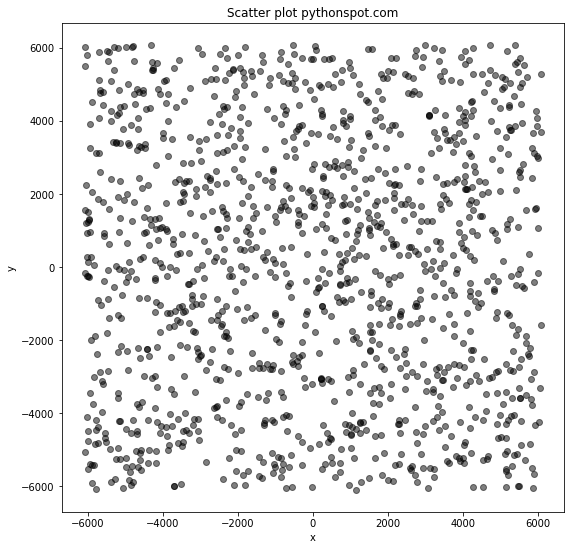

In [10]:
colors = (0,0,0)

plt.scatter(x.x, x.y, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')

fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.show()

## La idea principal del análisis de algoritmo seleccionado consiste en solucionar el problema desde la perspectiva de un diagrama de voronoi, el cual nos podrá mostrar a simple vista los puntos convexos y esos son los que a mi parecer se deben buscar. Una vez identificados será fácil pedirle al algoritmo que regrese al total de puntos.

### Nota: también se puede resolver esto por medio del algoritmo de Traingulación Delaunay o por el algoritmo de Bowyer-Watson.

#### Referencias: http://paulbourke.net/papers/triangulate/

<img src="../images/gifs/Fortunes-algorithm-slowed.gif" style="width: 30%;">

In [11]:
x_arr = X.iloc[:,:].values
points = x_arr

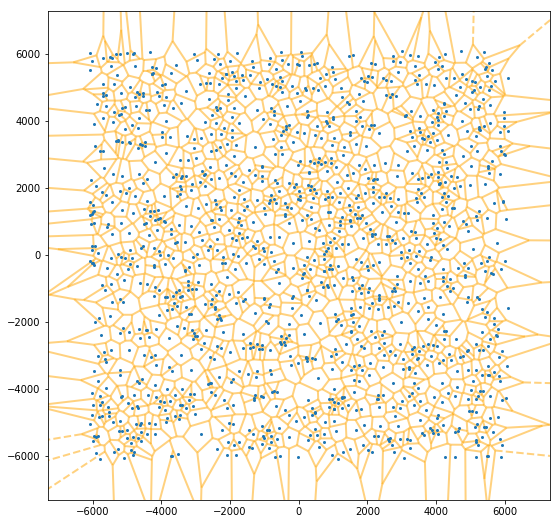

In [12]:
vor = Voronoi(x_arr)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.5, point_size=4)
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.show()

## La triangulación de Delaunay es una red de triangulos conexa y convexa que cumple la ley de Delaunay, estos triángulos deben estar dentro de un círculo circunstcrito y ningún otro vértices de otro triángulo deberá estar dentro del círculo

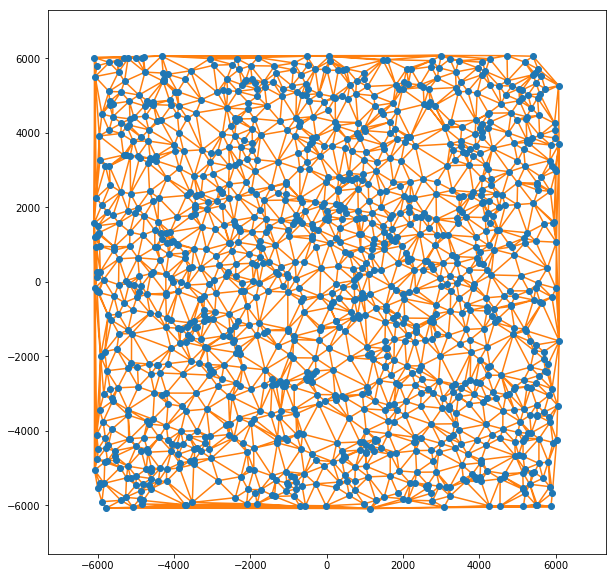

In [13]:
tri = Delaunay(points)
fig = delaunay_plot_2d(tri)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

### Ahora bien, se me ha ocurrido calcular la distancia entre los puntos por medio del centro geométrico de cada conglomerado de puntos, es decir, la posición media aritmética de todos los puntos en el plano. Es como sí colocáramos un objeto perfectamente equilibrado encima de la punta de un alfiler y éste se quedara ahí, balanceando su centro de masa a 0°.

<img src="../images/png/800px-Stereographic_projection_in_3D.svg.png" style="width: 20%;">

In [14]:
eps = sys.float_info.epsilon
bounding_box = np.array([0.0, 10000.0, 0.0, 10000.0])

In [15]:
def in_box(arch_pts, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= points[:, 0],
                                         points[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= points[:, 1],
                                         points[:, 1] <= bounding_box[3]))

Total regions by centroid:  336
Total points near centroid:  678


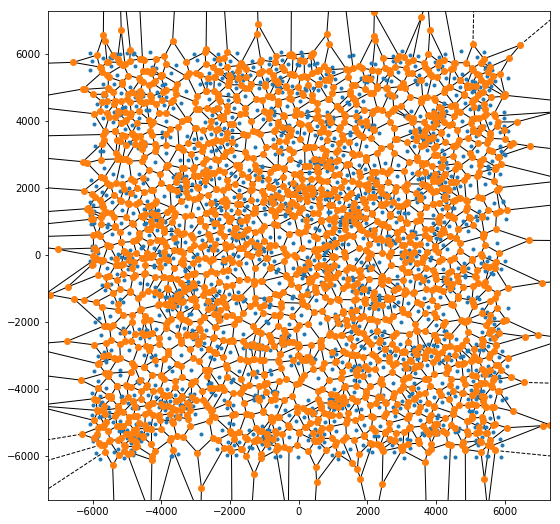

In [16]:
def voronoi_selection(arch_pts, bounding_box):
    i = in_box(arch_pts, bounding_box)
    
    points_center = arch_pts[i,:]
    points_left = np.copy(points_center)
    points_left[:,0] = bounding_box[0] - (points_left[:,0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:,0] = bounding_box[1] + (bounding_box[1] - points_right[:,0])
    points_down = np.copy(points_center)
    points_down[:,1] = bounding_box[2] - (points_down[:,1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:,1] = bounding_box[3] + (bounding_box[3] - points_up[:,1])
    pts = np.append(points_center,
                   np.append(np.append(points_left,
                                       points_right,
                                       axis=0),
                             np.append(points_down,
                                       points_up,
                                       axis=0),
                            axis=0),
                   axis=0)
    
    vor = Voronoi(pts)
    
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    print('Total regions by centroid: ', len(vor.filtered_regions))
    print('Total points near centroid: ', vor.filtered_points.size)
    return vor       

voronoi_selection(points, bounding_box)
voronoi_plot_2d(vor)
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.show()

In [17]:
def centroid_region(vertices):
    Area = 0
    Centroid_x = 0
    Centroid_y = 0
    
    for i in range(0, len(vertices) - 1):
        s = (vertices[i,0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        Area = Area + s
        Centroid_x = Centroid_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        Centroid_y = Centroid_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    Area = 0.5 * Area
    Centroid_x = (1.0 / (0.6 * Area)) * Centroid_x
    Centroid_y = (1.0 / (0.6 * Area)) * Centroid_y
    return np.array([[Centroid_x, Centroid_y]])

vor = voronoi_selection(points, bounding_box)

Total regions by centroid:  336
Total points near centroid:  678


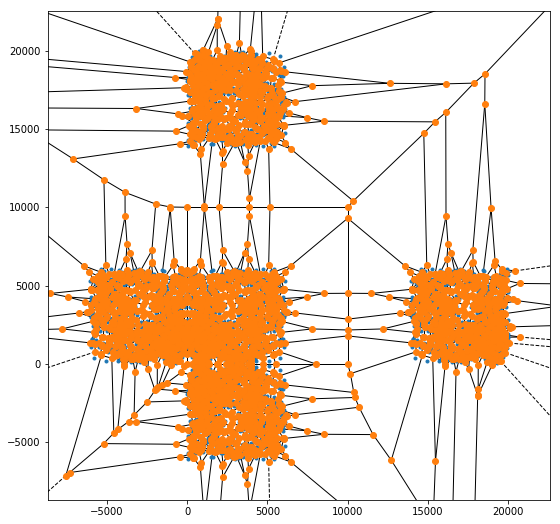

In [18]:
for region in vor.filtered_regions:
    vertices = vor.vertices[region, :]

for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]


centroids = []
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    centroid = centroid_region(vertices)
    centroids.append(list(centroid[0, :]))

voronoi_plot_2d(vor)
fig = plt.gcf()
fig.set_size_inches(9, 9)
plt.show()